# ------------- User's settings -------------
This is the only section you need to make inputs

In [1]:
# Output from Step1 is needed as input here
input_directory = ['../Data/Step1/Output/']


# Output location for this step
output_directory = '../Data/Step2/Output/'


# Define labels of the classes
labels = ["SmoothDisc", 
          "CrenatedDisc_", 
          "CrenatedDiscoid", 
          "CrenatedSpheroid", 
          "CrenatedSphere",
          "SmoothSphere", 
          "Side"
         ]


# Exclude any object that has metadata :
exclusion = ['ce52', 'undecidable']


# Define other metadata
day_of_exp = [str('D'+str(i)) for i in list(range(1,100))] 


# If using Conda, specifying the path for Python site-packages might be needed
import sys
# sys.path.insert(0, '/home/user/.conda/envs/env_names/lib/python3.6/site-packages')

# ------------- Executable -------------
Execute the rest of the script

Beware: it may take very long, read below!

In [2]:
import glob
import os
import keras
import matplotlib.pyplot
import numpy
import pandas
import pkg_resources
import tensorflow
import skimage.io
import deepometry.model_classification as deepometry_model
import deepometry.utils
import itertools
import re
from collections import Counter

# Choose GPU to run training session
configuration = tensorflow.ConfigProto()
configuration.gpu_options.visible_device_list = "1"

Using TensorFlow backend.


In [3]:
def collect_pathnames(directories, labels):
    """
    :param directories: List of directories to select samples from, e.g. data can be pooled from multiple sources.
                        Assumes subdirectories of each directory correspond to class labels.
                        Contents of subdirectories are NPY files containing data of that label.
    :return: List of pathnames.
    """
    pathnames = []

    for directory in directories:
        subdirectories = sorted(glob.glob(os.path.join(directory, "*")))
        
        # transform the files of the same label into directory
        filelist = [glob.glob("{}/*{}*".format(subdirectory,label)) for label in labels for subdirectory in subdirectories ]
        
        subdirectory_pathnames = []
        for i in range(len(labels)):
            a = filelist[i*len(subdirectories):(i+1)*len(subdirectories)]
            subdirectory_pathnames.append( list(itertools.chain.from_iterable(a)) )        

        nsamples = max([len(pathnames) for pathnames in subdirectory_pathnames])
        #nsamples = min([len(pathnames) for pathnames in subdirectory_pathnames])
        #nsamples = 250000

        pathnames += [list(numpy.random.permutation(pathnames)[:nsamples]) for pathnames in subdirectory_pathnames]

    pathnames = sum(pathnames, [])

    return pathnames


def load(pathnames, labels, dates):

    print('Before exclusion: ', len(pathnames))
    pathnames_to_exlude = [i for i in pathnames if numpy.load(i).shape[2] > 3]
    print('Problematic cells:')
    print(pathnames_to_exlude)
    pathnames = list(set(pathnames) - set(pathnames_to_exlude))    
    pathnames = [x for x in pathnames if numpy.all([not z.lower() in x.lower() for z in exclusion])]          
    print('After exclusion: ', len(pathnames))
    
    x = numpy.empty((len(pathnames),) + _shape(pathnames[0]), dtype=numpy.uint8)

    y = numpy.empty((len(pathnames),), dtype=numpy.uint8)
    
    z = numpy.empty((len(pathnames),), dtype=numpy.uint8)
    
    b = numpy.empty((len(pathnames),), dtype=numpy.uint8)

    label_to_index = {label: index for index, label in enumerate(sorted(labels))}
    
    day_to_index = {day: index for index, day in enumerate(day_of_exp)}
    
    bb = list(set([re.search('.*_([A-Za-z0-9]*)_[DdWw][0-9]{1,2}_.*_.*__', os.path.basename(path)).group(1) for path in glob.glob(os.path.join(input_directory[0],'**/*'))]))
    bagID_to_b_index = {bag: index for index, bag in enumerate(sorted(bb))}

    for index, pathname in enumerate(pathnames):
        if os.path.isfile(pathname) == True:

            match = re.search('.*_[A-Za-z0-9]*_([DdWw][0-9]{1,2})_.*_.*__', os.path.basename(pathname))
            day = str(match.group(1))  
            del(match)
            
            match = re.search('.*_([A-Za-z0-9]*)_[DdWw][0-9]{1,2}_.*_.*__', os.path.basename(pathname))
            bagID = str(match.group(1))
            
            label = os.path.split(os.path.dirname((pathname)))[1]
            if label == 'CrenatedDisc':
                label = str(label + "_")
       
            #print(pathname)
            x[index] = numpy.load(pathname)

            y[index] = label_to_index[label]
            
            z[index] = day_to_index[day]
            
            b[index] = bagID_to_b_index[bagID]

    return x, y, z, b


def _shape(pathname):
    """
    Infer the shape of the sample data from a single sample.   
    :param pathname: Path to a sample.
    :return: Sample dimensions.
    """
    return numpy.load(pathname).shape                


def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

In [4]:
pathnames = collect_pathnames(input_directory, labels)

xx, y, z, b = load(pathnames, labels, day_of_exp)  

Before exclusion:  2384
Problematic cells:
[]
After exclusion:  1642


Re-order the channel if needed.

For example:

- When using TIFF input, data may be structured as Brightfield_1 - Darkfield - Brightfield_9
- When using CIF input, data may be structured as Brightfield_1 - Brightfield_9 - Darkfield

In [5]:
# x = numpy.empty((xx.shape[0],48,48,3))
# x[:,:,:,0] = xx[:,:,:,0]
# x[:,:,:,1] = xx[:,:,:,2]
# x[:,:,:,2] = xx[:,:,:,1]
# del(xx)
x = numpy.empty((xx.shape[0],48,48,2))
x[:,:,:,0] = xx[:,:,:,2]
x[:,:,:,1] = xx[:,:,:,1]
del(xx)

print("x: ", x.shape)
print("y: ", y.shape)
print(Counter(y))
print("z: ",Counter(z))
print("b: ",Counter(b))

x:  (742, 48, 48, 2)
y:  (742,)
Counter({1: 112, 4: 112, 2: 108, 5: 108, 0: 104, 3: 101, 6: 97})
z:  Counter({48: 742})
b:  Counter({1: 742})


------------- Verify loaded images -------------

/Users/minhdoan/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


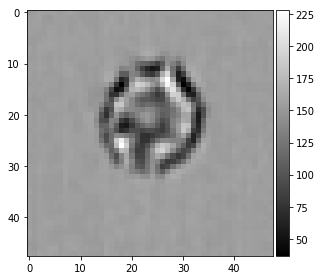

In [8]:
skimage.io.imshow(x[5,:,:,0], cmap='gray')

------------- Train the neural network -------------

Beware: this step may take hours, days, or weeks

In [9]:
class_weight = get_class_weights(y)

configuration.gpu_options.allow_growth = True
session = tensorflow.Session(config = configuration)
# apply session
keras.backend.set_session(session)

model = deepometry_model.Model(shape=x.shape[1:], units=len(labels))

model.compile()

In [ ]:
model.fit(
    x,
    y,
    class_weight = class_weight,
    batch_size=128,
    epochs=512,
    validation_split=0.2,
    verbose=1
)

Epoch 1/512
1/4 [======>.......................] - ETA: 3:03 - loss: 11.6131 - acc: 0.1406

------------- Save the trained neural network -------------

In [ ]:
if not os.path.exists(output_directory):
     os.makedirs(output_directory)
    
model.model.save( os.path.join(output_directory, 'model.h5') )